<a href="https://colab.research.google.com/github/ankitbit/Deep_Learning/blob/master/Assignment%20reports/Assignment%202/Product_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
! pip install gensim
! pip install nltk

In [0]:
# Importing major libraries
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical


MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

EMBEDDING_FILE = "GoogleNews-vectors-negative300.bin"
category_index = { 'LEGO':0, 
                   'Disney':1, 
                   'Oxford Diecast':2,
                   'Playmobil':3,
                   'Star Wars':4,
                   'The Puppet Company':5,
                   'Hasbro':6,
                   'Mattel':7}
category_reverse_index = dict((y,x) for (x,y) in category_index.items())

In [357]:
category_reverse_index

{0: 'LEGO',
 1: 'Disney',
 2: 'Oxford Diecast',
 3: 'Playmobil',
 4: 'Star Wars',
 5: 'The Puppet Company',
 6: 'Hasbro',
 7: 'Mattel'}

In [358]:
! wget 'https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/amazon_co-ecommerce_sample.csv'
datasets = pd.read_csv('amazon_co-ecommerce_sample.csv', sep=',')
datasets = datasets[['description', 'manufacturer']]

--2018-11-13 21:03:22--  https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/amazon_co-ecommerce_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35284814 (34M) [text/plain]
Saving to: ‘amazon_co-ecommerce_sample.csv.6’

amazon_co-ecommerce 100%[===================>]  33.65M  43.8MB/s    in 0.8s    

2018-11-13 21:03:24 (43.8 MB/s) - ‘amazon_co-ecommerce_sample.csv.6’ saved [35284814/35284814]



In [359]:
# Examination of null values
print("Make sure there are no null values in the datasets")
print("Has null values: ", datasets.isnull().values.any())

datasets = datasets.dropna()
print("Has null values: ", datasets.isnull().values.any())

Make sure there are no null values in the datasets
Has null values:  True
Has null values:  False


In [360]:
datasets.head(6)

,description,manufacturer
0,Product Description Hornby 2014 Catalogue Box ...,Hornby
1,Size Name:Large FunkyBuys® Large Christmas Hol...,FunkyBuys
2,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,ccf
3,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Hornby
4,Product Description Hornby RailRoad 0-4-0 Gild...,Hornby
5,These delicate model garden lights are mainly ...,Generic


In [0]:
grouped = datasets.groupby('manufacturer').count().reset_index()
grouped = grouped.sort_values(['description'], ascending=False)
category_names= [val for val in grouped['manufacturer'][0:8]]


In [0]:
data = pd.DataFrame()
for name in category_names:
  data = data.append(datasets[datasets['manufacturer']==name])

In [0]:
dataset = data
category = data['manufacturer']
data = data['description']

def preprocess(text):
    text= text.strip().lower().split()
    return " ".join(text)

datasets['description'] = datasets['description'].apply(preprocess)

In [0]:
category = pd.get_dummies(list(category))
category = np.array(category)

In [325]:
category.shape

(1046, 8)

In [326]:
data.shape

(1046,)

In [0]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(datasets['description'])

datasets_sequences = tokenizer.texts_to_sequences(data)
padded_data = pad_sequences(datasets_sequences, maxlen= MAX_SEQUENCE_LENGTH)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_data, category, test_size=0.25, random_state=42)

In [13]:
! wget 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

--2018-11-13 16:46:48--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.0.35
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.0.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  26.0MB/s    in 26s     

2018-11-13 16:47:14 (61.3 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
! gunzip GoogleNews-vectors-negative300.bin.gz

In [0]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [367]:
from keras.layers import Embedding
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Null word embeddings: 13201


In [368]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


model2 = Sequential()
model2.add(embedding_layer)
model2.add(Flatten())
model2.add(Dense(8,activation='sigmoid'))
model2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 300)           9858600   
_________________________________________________________________
flatten_9 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 72008     
Total params: 9,930,608
Trainable params: 72,008
Non-trainable params: 9,858,600
_________________________________________________________________


In [369]:
history_model = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=128)
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 784 samples, validate on 262 samples
Epoch 1/50
784/784 [==============================] - 1s 740us/step - loss: 1.9388 - acc: 0.3584 - val_loss: 1.7573 - val_acc: 0.4771
Epoch 2/50
784/784 [==============================] - 0s 51us/step - loss: 1.5460 - acc: 0.7041 - val_loss: 1.5976 - val_acc: 0.5382
Epoch 3/50
784/784 [==============================] - 0s 51us/step - loss: 1.2845 - acc: 0.8176 - val_loss: 1.4881 - val_acc: 0.5725
Epoch 4/50
784/784 [==============================] - 0s 48us/step - loss: 1.0845 - acc: 0.8992 - val_loss: 1.4084 - val_acc: 0.5916
Epoch 5/50
784/784 [==============================] - 0s 49us/step - loss: 0.9289 - acc: 0.9222 - val_loss: 1.3433 - val_acc: 0.5802
Epoch 6/50
784/784 [==============================] - 0s 49us/step - loss: 0.8065 - acc: 0.9349 - val_loss: 1.3014 - val_acc: 0.6107
Epoch 7/50
784/784 [==============================] - 0s 56us/step - loss: 0.7041 - acc: 0.9528 - val_loss: 1.2727 - val_acc: 0.6107
Epoch 8/50
784/784 [==

In [0]:
from keras.layers import Embedding
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [385]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(150,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(8,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 300)           9858600   
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 300)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 14, 300)           270300    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6, 150)            135150    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2, 75)             33825     
_________________________________________________________________
flatten_10 (Flatten)         (None, 150)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 150)               0         
__________

In [383]:

model_1 = Sequential()
model_1.add(embedding_layer)
model_1.add(Conv1D(250,3,padding='valid',activation='relu',strides=1))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(250))
model_1.add(Dropout(0.2))
model_1.add(Activation('relu'))
model_1.add(Dense(8))
model_1.add(Activation('sigmoid'))
model_1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 300)           9858600   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 28, 250)           225250    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 250)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_16 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_12 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 2008      
__________

In [389]:
history_model = model.fit(X_train, y_train, validation_split=0.4, epochs=500, batch_size=128)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 470 samples, validate on 314 samples
Epoch 1/500
470/470 [==============================] - 0s 175us/step - loss: 0.1521 - acc: 0.9340 - val_loss: 2.4713 - val_acc: 0.5287
Epoch 2/500
470/470 [==============================] - 0s 168us/step - loss: 0.1519 - acc: 0.9319 - val_loss: 2.4909 - val_acc: 0.5318
Epoch 3/500
470/470 [==============================] - 0s 175us/step - loss: 0.1473 - acc: 0.9362 - val_loss: 2.5429 - val_acc: 0.5159
Epoch 4/500
470/470 [==============================] - 0s 169us/step - loss: 0.1476 - acc: 0.9319 - val_loss: 2.5769 - val_acc: 0.5223
Epoch 5/500
470/470 [==============================] - 0s 173us/step - loss: 0.1467 - acc: 0.9362 - val_loss: 2.5019 - val_acc: 0.5350
Epoch 6/500
470/470 [==============================] - 0s 172us/step - loss: 0.1556 - acc: 0.9255 - val_loss: 2.5331 - val_acc: 0.5382
Epoch 7/500
470/470 [==============================] - 0s 179us/step - loss: 0.1391 - acc: 0.9426 - val_loss: 2.4548 - val_acc: 0.5032
Epoch 8/5

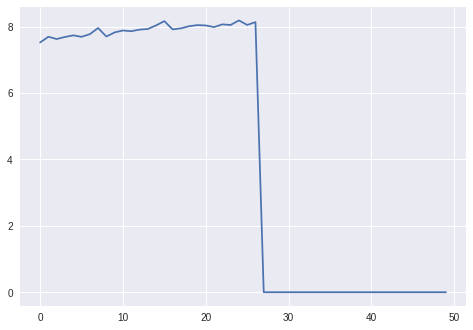

In [296]:
import matplotlib.pyplot as plt
plt.plot(history_model_1.history['val_loss'])

In [295]:
history_model_1 = model_1.fit(X_train, y_train, validation_split=0.4, epochs=50, batch_size=128)
score = model_1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3364 samples, validate on 2243 samples
Epoch 1/50
3364/3364 [==============================] - 0s 144us/step - loss: 0.3748 - acc: 0.9194 - val_loss: 7.5266 - val_acc: 0.2657
Epoch 2/50
3364/3364 [==============================] - 0s 127us/step - loss: 0.3219 - acc: 0.9307 - val_loss: 7.6976 - val_acc: 0.2590
Epoch 3/50
3364/3364 [==============================] - 0s 119us/step - loss: 0.3094 - acc: 0.9313 - val_loss: 7.6302 - val_acc: 0.2679
Epoch 4/50
3364/3364 [==============================] - 0s 110us/step - loss: 0.2799 - acc: 0.9322 - val_loss: 7.6922 - val_acc: 0.2778
Epoch 5/50
3364/3364 [==============================] - 0s 116us/step - loss: 0.2532 - acc: 0.9402 - val_loss: 7.7405 - val_acc: 0.2639
Epoch 6/50
3364/3364 [==============================] - 0s 115us/step - loss: 0.2401 - acc: 0.9429 - val_loss: 7.6966 - val_acc: 0.2769
Epoch 7/50
3364/3364 [==============================] - 0s 116us/step - loss: 0.2291 - acc: 0.9423 - val_loss: 7.7754 - val_acc: 0.2639


In [382]:
example_product = 'The holidays are coming to LEGO City, one gift'
example_product = preprocess(example_product)
example_sequence = tokenizer.texts_to_sequences([example_product])
example_padded_sequence = pad_sequences(example_sequence, maxlen=MAX_SEQUENCE_LENGTH)

print("-"*10)
print("Predicted category: ", category_reverse_index[model2.predict_classes(example_padded_sequence, verbose=0)[0]])
print("-"*10)
probabilities = model2.predict(example_padded_sequence, verbose=0)
probabilities = probabilities[0]


----------
Predicted category:  LEGO
----------


In [376]:
dataset

614     The holidays are coming to LEGO City, one gift...
626     Product Description LEGO Friends Advent Calend...
627     Product Description LEGO® Star Wars™ Jek-14’s ...
634     Manufacturer's Description 24 days of LEGO® Ci...
651     Product Description LEGO® Star Wars™ Corporate...
720     Lego 7553 - City - Advent Calendar It's Christ...
739     Celebrate 24 December days full of medieval bu...
740         Lego Castle Advent Calendar 7979 NEW / SEALED
748     Jedi Master Saesee Tiin is patrolling for Sepa...
760     Product Description Count down to a LEGO Frien...
765     Product Description Count down to a LEGO Frien...
1142    LEGO Super Heroes: Plastic Man Set 5004081 (Ba...
1167    Brand New Minifigure from LEGO. Includes Weapo...
2395    Product Description The Malevolence is General...
2397                     LEGO Racers 8384: Jungle Crasher
2399    Product Description LEGO® Galaxy Squad Hive Cr...
2405    Product Description Build a LEGO brick model o...
2408       LEG

In [27]:
# Wikipedia 2014
! wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2018-11-13 17:32:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-11-13 17:32:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.57MB/s    in 8m 9s   

2018-11-13 17:40:40 (1.68 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [32]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html